## Dependencies

### Install following (if not already available in docker container)

```
apt-get install ffmpeg libsm6 libxext6  -y
```

### Install python wrapper

```
pip install opencv-contrib-python
```

### Install OCR package

```
apt install tesseract-ocr
pip install pytesserat
```

### Install 7 segment trained data

Derived from: git clone https://github.com/Shreeshrii/tessdata_ssd
```
cp trained_data/7seg.traineddata /usr/share/tesseract-ocr/4.00/tessdata
cp trained_data/ssd.traineddata /usr/share/tesseract-ocr/4.00/tessdata
cp trained_data/ssd_int.traineddata /usr/share/tesseract-ocr/4.00/tessdata
```
Note: 7seg seems to be best for LCD display.


In [16]:
from ipywidgets import interact
import cv2
import numpy as np
import pytesseract

from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (8.0, 6.0) # this controls figure size in the notebook

img_path = './images/LCD_heating_18.jpeg'

### Thresholding Approach

Work out the best thresholding approach to maximise contour detection and Hough transform line detection. 

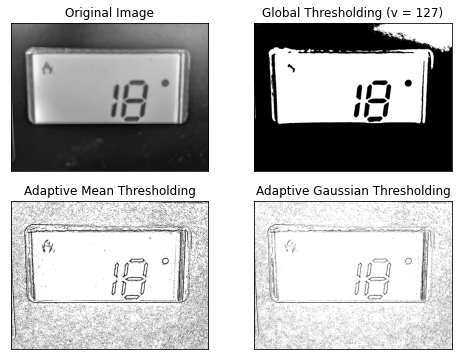

In [17]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_blur = cv2.medianBlur(img,5)

ret,th1 = cv2.threshold(img_blur,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img_blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img_blur, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

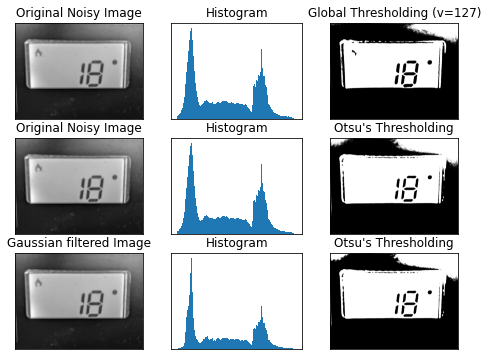

In [23]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# global thresholding
ret1, th1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Otsu's thresholding
ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img, (5,5), 0)
ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]

titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

### Edge Detection

Canny edge detect.

In [19]:
def canny(Value):
    edges = cv2.Canny(th3, Value, 200, 255)
    plt.imshow(edges, cmap = 'gray')
    plt.title('Canny Edge Detection')
    
interact(canny,Value=(1,255,2))

edges = cv2.Canny(th3, 127, 200, 255)

interactive(children=(IntSlider(value=127, description='Value', max=255, min=1, step=2), Output()), _dom_class…

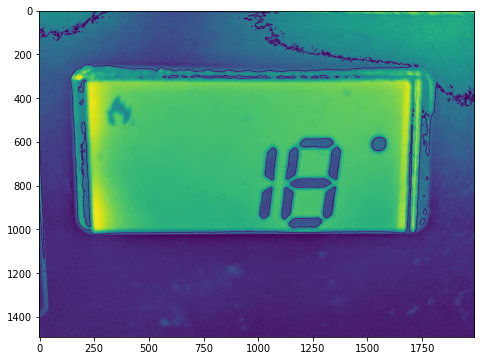

In [52]:
# Find contours
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
cnts = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for cnt in cnts:
    approx = cv2.contourArea(cnt)
    if (approx > 1000):
        print(approx)
        #print(cnt)

cv2.drawContours(image=img, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
plt.imshow(img)

### Line Detection

Find lines using Hough transform.

In [22]:
def hough(Value):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, Value, minLineLength=200, maxLineGap=250) # hough transform

    # Draw lines on the image
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
    plt.imshow(img, cmap='gray')
    plt.title("Hough result")
    
interact(hough,Value=(1,255,2))

interactive(children=(IntSlider(value=127, description='Value', max=255, min=1, step=2), Output()), _dom_class…

<function __main__.hough(Value)>

### Find Inner Trapezoid

Attempt contour search to find a trapizoid or near rectangle

### OCR Segmented Image

18



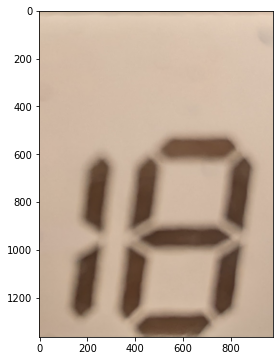

In [6]:
input_image = cv2.imread('./images/LCD_heating_18_segmented.jpeg')

plt.imshow(input_image)

# Cvt to hsv
hsv = cv2.cvtColor(input_image, cv2.COLOR_BGR2HSV)

# Get binary-mask
msk = cv2.inRange(hsv, np.array([0, 0, 175]), np.array([179, 255, 255]))
krn = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3))
dlt = cv2.dilate(msk, krn, iterations=1)
thr = 255 - cv2.bitwise_and(dlt, msk)

# OCR
d = pytesseract.image_to_string(input_image, config="-l 7seg --psm 8") # best
#d = pytesseract.image_to_string(thr, config="-l ssd_int --psm 8")
#d = pytesseract.image_to_string(thr, config="-l 7seg --psm 8")
print(d)